## What is Attention?

Imagine you're reading a sentence and trying to understand the meaning of a particular word. You might look at other words in the sentence to get context. In NLP, the attention mechanism allows models to do something similar: focus on relevant parts of the input when processing information.

For example, in the sentence "The animal didn't cross the street because it was too tired," understanding what "it" refers to requires attention to "The animal." Attention mechanisms help models make these connections.



##### Attention is a mechanism that lets a model decide which parts of the input are important when processing or generating each output — rather than treating all inputs equally.

Imagine you're reading a sentence to answer a question like:

"What is the capital of France?"

You'd probably focus your attention on the word "France" in the sentence:

"Paris is the capital of France."

Even though the sentence has many words, your brain gives more weight to the most relevant word — "France" — to find the answer.

##### In a Transformer model:

When processing a word (say at position t), the model uses attention to look at all the other words in the sentence, and assigns a score to each — representing how important they are for understanding word t.

##### How it works (briefly):
1. Each token gets transformed into three vectors: Query (Q), Key (K), and Value (V)

2. Attention computes scores between Query and Key → this tells us how much focus (or attention) to place on each token.

3. These scores are then used to weight the Value vectors → giving a weighted sum that becomes the attention output.

#### Simple Explanation:
Imagine you’re processing the sentence:

“The cat sat on the mat.”

To understand the word “sat”, the model looks at all other words in the sentence — “The,” “cat,” “on,” “the,” “mat” — and decides how much each contributes to understanding “sat.”

In self-attention, every word:

Looks at every other word (including itself),

Decides how important each is,

Then combines that information to update its own representation.

##### Why “self”?
Because the attention is within the same sequence — each token is attending to itself and its neighbors.


For each token in the input:

1. Create Query, Key, and Value vectors.

2. Use the Query of this token with Keys of all tokens to get attention scores.

3. Apply softmax to turn scores into weights.

4. Multiply these weights with Value vectors to get a new, context-aware representation of that token.

Self-attention lets each token in a sequence gather information from the entire sequence to better understand its context.

## Multi-Head Attention

###### What Is Multi-Head Attention?

Multi-head attention is a core concept in Transformer neural networks. It allows the model to focus on different parts of the input sequence simultaneously, capturing various relationships and patterns within the data. Rather than calculating attention just once, multi-head attention splits computations into several “heads,” each with separate projections of Query (Q), Key (K), and Value (V) vectors. Each head processes the input differently, and the results are combined at the end.


https://www.geeksforgeeks.org/nlp/multi-head-attention-mechanism/

https://d2l.ai/chapter_attention-mechanisms-and-transformers/multihead-attention.html


##### Tutorial Notebook :
https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html

#### Summary in 1-liners:
Attention: Focus on another sequence to extract what matters.

Self-Attention: Focus within the same sequence to understand relationships.

Multi-Head Attention: Use several attention mechanisms in parallel to get richer context.



## Transformer Architecture Overview
Core Components of a Transformer

1. Input Embeddings: Raw text is first tokenized into discrete tokens. Each token is mapped to a high-dimensional vector, known as its embedding.

###### Sources: 

https://symbl.ai/developers/blog/a-guide-to-transformer-architecture/

https://www.geeksforgeeks.org/machine-learning/getting-started-with-transformers/

2. Positional Encoding: Since Transformers don’t inherently process data sequentially, positional information is injected by adding positional encodings (often sine and cosine functions of varying frequencies) to each embedding, so the model knows the order of the sequence

###### Sources:

https://www.geeksforgeeks.org/machine-learning/getting-started-with-transformers/

Most Transformers—especially in text-to-text tasks—are built with two major parts: an encoder and a decoder. Each consists of several identical layers (e.g., six encoder + six decoder layers in the original design).

1. Encoder Layers

Each encoder layer includes:

- **Multi-Head Self-Attention Mechanism:** Allows every token to "attend" to every other token and decide which are most relevant, from multiple perspectives ("heads").

- **Feedforward Neural Network (Position-wise FFN):** Applies the same dense two-layer perceptron to each token's representation, independently.

- **Residual Connections & LayerNorm:** Skip connections wrap both attention and feedforward sub-layers, stabilized by layer normalization.

2. Decoder Layers

Each decoder layer includes:

- **Masked Multi-Head Self-Attention:** Ensures that future tokens cannot be seen, preserving autoregressive properties for sequence generation.

- **Encoder-Decoder Attention:** Lets each position in the decoder attend across all encoder outputs, learning correspondences between source and target sequences.

- **Feedforward Neural Network**

- **Residual Connections & LayerNorm**

3. Output Layers

- **Linear Projection:** The decoder output is linearly transformed into logits, mapping to vocabulary size.

- **Softmax Layer:** Converts logits into probabilities for predicting the next token

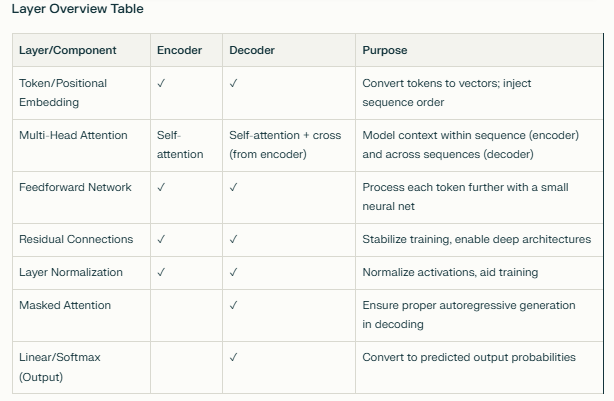

# Attention and Transformers

We will demonstrate how attention mechanisms work, how they can be implemented and their use within model based on transformer architectures. We will develop an understanding from first principles using PyTorch for creating and manipulating tensors.

Ultimately, we're aiming to demystify what's' happening within PyTorch's high-level transformer modules: [torch.nn.TransformerEncoderLayer](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer) and [torch.nn.TransformerDecoderLayer](https://pytorch.org/docs/stable/generated/torch.nn.TransformerDecoderLayer.html#torch.nn.TransformerDecoderLayer).

Attention mechanisms aim to map [word embeddings](https://en.wikipedia.org/wiki/Word_embedding) from one vector space into another, based on the other word embeddings in the sequence. This produces context-aware embeddings.

We could express this mapping mathematically as, $\textbf{x} \to \textbf{z} = f(\textbf{x})$, where $\textbf{x} = (\vec{x_{1}}, ..., \vec{x_{N}})$, $\textbf{z} = (\vec{z_{1}}, ..., \vec{z_{N}})$, $\vec{x}$ and $\vec{z}$ are $d$-dimensional embedding vectors and $N$ is the number of tokens in the sequence. The goal of attention is to learn $f$ from data to solve machine learning tasks such as sequence-to-sequence translation.

## Imports

We will mostly be using PyTorch like NumPy (to create and manipulate tensors), but we will also use one or two modules from its neural networks module, `torch.nn`.

In [1]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

## Example Text

Let's start with a sentence

In [2]:
sentence = "Sorry Dave, I'm afraid I can't do that."

In [3]:
sentence = "Monika likes music, dance and is fun-loving."

We then [tokenize](https://en.wikipedia.org/wiki/Lexical_analysis#Tokenization) our sentence into a sequence of integer values (one for each word), using an imaginary tokenization function.

In [6]:
def tokenize(text: str, vocab_size: int) -> torch.Tensor:
    """Dummy text tokenizer."""
    words = text.split(" ")
    return torch.randint(0, vocab_size, [len(words)])


VOCAB_SIZE = 20000

tokenized_sentence = tokenize(sentence, VOCAB_SIZE)
n_tokens = len(tokenized_sentence)
tokenized_sentence

tensor([ 2234, 12258,  2577,  1811, 11443,  8094, 11141])

# And embed each token into a vector space using PyTorch's [torch.nn.Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html#torch.nn.Embedding) module.


This image shows how the embedding layer in a neural network (like a transformer) works:

1. Input tokens (such as words or subwords) are represented as symbols (like “V”, “B”, etc.) on the right.

2. Each token is mapped to a unique vector (a row of numbers), seen as colored circles and columns in the middle.

3. The embedding layer transforms each token into its corresponding numerical vector (embedding), stacking these vectors together to form the input for the rest of the model.

In short: The embedding layer turns text tokens into high-dimensional numeric representations that the model can understand and process further.


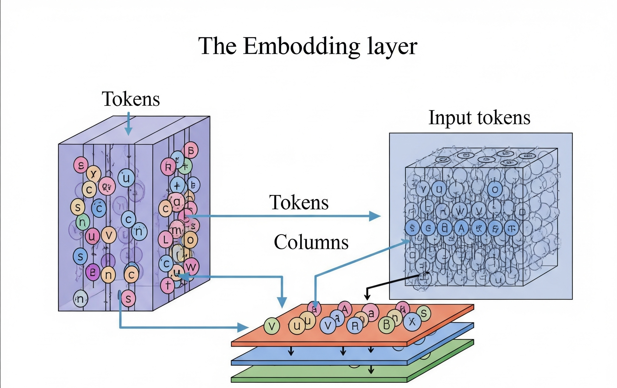

In [11]:
EMBEDDING_DIM = 32

embedding_layer = nn.Embedding(VOCAB_SIZE, EMBEDDING_DIM)
embedded_tokens = embedding_layer(tokenized_sentence)
embedded_tokens.shape

torch.Size([7, 32])

In [12]:
embedded_tokens

tensor([[-0.2253,  0.2497, -1.1754,  0.2287,  1.4755, -1.0894, -0.1193, -0.3228,
          0.7992, -0.7057, -0.1752, -0.2282,  1.8326,  0.4277,  0.2197,  1.8641,
         -0.8864, -0.1457, -0.4423,  0.8133,  1.1743, -1.0198, -0.2640, -1.1858,
         -2.5800,  1.5745, -1.5092,  1.3402,  1.1474, -1.8551,  1.8958,  1.0653],
        [ 0.0830,  0.0140,  3.2837,  0.0520,  0.3730, -0.4747, -1.3035,  0.4887,
          1.7115,  1.0137,  0.0912, -0.5028,  0.2306, -0.8762,  1.6046,  0.9129,
         -1.5339, -0.1920, -1.7881,  1.0637,  0.4946, -0.7068,  0.1461, -0.9147,
          1.2227, -0.6066,  0.7718,  0.8236,  0.1786, -0.2665,  0.3326,  0.3344],
        [ 1.6500, -0.3156,  1.6657,  0.0661, -0.9162, -0.0310,  0.5812,  1.3433,
         -0.3940, -0.1911, -0.5342,  0.5856, -0.5404,  0.6067,  0.0269, -0.9161,
          0.0728,  1.0287, -0.6641,  0.1468,  0.5818,  0.6254, -0.3987, -1.3884,
         -1.4989, -0.3997, -0.4050,  1.8198,  0.3459,  0.3989, -2.4381,  0.2008],
        [-0.7288, -0.3573

- A higher embedding dimension allows the model to capture more complex and nuanced features of the data, but increases memory and computation requirements.

- A lower embedding dimension is more efficient, but might not capture all the important information, especially for complex tasks or large vocabularies.

These embeddings will need to be learnt when training any model that uses an embedding layer. We can easily compute the number of parameters that need to be learnt.

In [13]:
n_embedding_params = sum(len(p.flatten()) for p in embedding_layer.parameters())
print(f"number of embedding parameters = {n_embedding_params:,}")

number of embedding parameters = 640,000


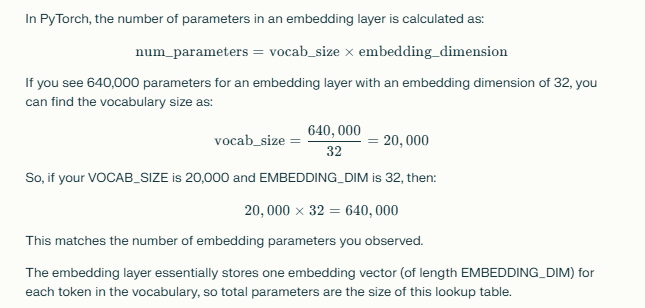

## Basic Self-Attention

An approach to computing attention is to express the new context-aware embeddings as a weighted linear combination or the input embeddings - e.g., $\vec{x_{i}} \to \vec{z_{i}} = \sum_{j=1}^{N}{a_{ij} \times \vec{x_{j}}}$. 

One sensible approach to computing the weights is to use the vector [dot product](https://en.wikipedia.org/wiki/Dot_product) between the embedding vectors - e.g., $a_{ij} = x_{i}^{T} \cdot x_{i}$. This will lead to weights that are higher for embedding vectors that are geometrically nearer to one another in the embedding space (i.e., are semantically closer), and vice versa.

In [35]:
torch.empty(n_tokens, n_tokens) #allocates uninitialized memory for a tensor.

tensor([[-2.3284e-13,  9.0244e-43,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])

Self-attention in transformers computes **how much one token should consider every other token’s information to build context-aware representations.** 

Below code computes the core **similarity scores (unnormalized attention weights) using dot products between embeddings.**

For each token 

i = (acting as a query), we calculate the dot product with every other token j's

j = embedding vector (acting as keys).

In [39]:
attn_weights = torch.empty(n_tokens, n_tokens)


for i in range(n_tokens):
    for j in range(n_tokens):
        attn_weights[i, j] = torch.dot(embedded_tokens[i], embedded_tokens[j])

attn_weights.shape

torch.Size([7, 7])

In [37]:
attn_weights

tensor([[41.5684,  2.9620, -3.3347,  7.0310, -5.0803,  4.6272,  4.0975],
        [ 2.9620, 33.3249,  3.4162,  2.0424, -6.2918, -1.9210, -1.7666],
        [-3.3347,  3.4162, 27.3913, -2.5545,  1.3217, -6.6282,  2.8566],
        [ 7.0310,  2.0424, -2.5545, 35.5393, -2.5249,  0.7827, -5.6452],
        [-5.0803, -6.2918,  1.3217, -2.5249, 34.8047,  3.0419,  2.9859],
        [ 4.6272, -1.9210, -6.6282,  0.7827,  3.0419, 23.0754,  3.0073],
        [ 4.0975, -1.7666,  2.8566, -5.6452,  2.9859,  3.0073, 27.7376]],
       grad_fn=<CopySlices>)

This calculation can also be computed more efficiently using matrix multiplication.


#### OR

In [40]:
attn_weights_matmul = torch.matmul(embedded_tokens, embedded_tokens.T)

In [42]:
attn_weights_matmul 

tensor([[41.5684,  2.9620, -3.3347,  7.0310, -5.0803,  4.6272,  4.0975],
        [ 2.9620, 33.3248,  3.4162,  2.0424, -6.2918, -1.9210, -1.7666],
        [-3.3347,  3.4162, 27.3913, -2.5545,  1.3217, -6.6282,  2.8566],
        [ 7.0310,  2.0424, -2.5545, 35.5393, -2.5249,  0.7827, -5.6452],
        [-5.0803, -6.2918,  1.3217, -2.5249, 34.8047,  3.0419,  2.9859],
        [ 4.6272, -1.9210, -6.6282,  0.7827,  3.0419, 23.0754,  3.0073],
        [ 4.0975, -1.7666,  2.8566, -5.6452,  2.9859,  3.0073, 27.7376]],
       grad_fn=<MmBackward0>)

And we can verify that the two approaches are equivalent.

#### VALIDATING

In [43]:
torch.allclose(attn_weights_matmul, attn_weights, atol=1e-6)

True

When it comes to implementing this in practice the weights are scaled by the embedding dimension, and subsequently renormalised to sum to one across rows using the [softmax function](https://en.wikipedia.org/wiki/Softmax_function). Steps like these make models easier to train by normalising the magnitude of gradients used within algorithms like [stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent). Refer to [3] for more insight into this and related issues.

#### Revision

##### Attention: Allows a model to selectively focus on relevant parts of an input (source) sequence when producing an output (target), by learning importance weights.
##### Self-Attention: Enables elements within the same sequence to interact and weigh each other's significance, creating richer, context-aware representations for each element in that sequence.

# Let's break down the key points:

#### "the weights are scaled by the embedding dimension":

1. In the context of self-attention (a core component of transformers), the attention mechanism calculates "attention scores" (or "logits") between a query and all keys. These scores determine how much focus each part of the input sequence should get.


2. Before applying the softmax function, these attention scores are typically divided by the square root of the embedding dimension 


3. Why? This scaling is crucial to prevent the dot products (which are used to calculate the attention scores) from becoming very large as the embedding dimension increases. When dot products become very large, they can push the softmax function into regions where its gradients are extremely small (saturate), which can lead to vanishing gradients and hinder the training process. Dividing by square root of d, helps to keep the variance of the dot products consistent, regardless of the embedding dimension size. This concept is detailed in the original "Attention Is All You Need" paper by Vaswani et al.

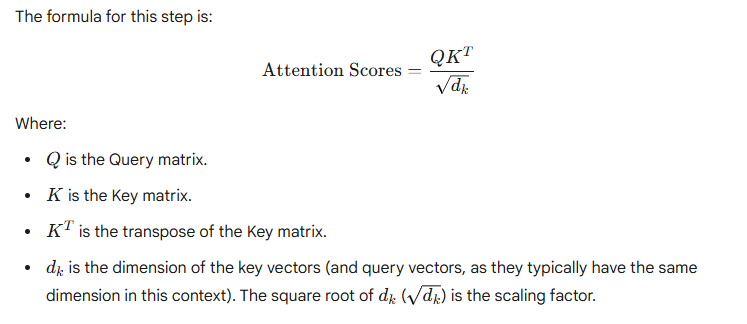

#### "and subsequently renormalised to sum to one across rows using the softmax function.":

1. After scaling, the attention scores are passed through a softmax function.


2. Why? The softmax function converts the raw attention scores into a probability distribution. This means that for each query, the attention weights assigned to all keys will be positive and sum up to 1. These normalized weights then determine how much each key contributes to the weighted sum that forms the attention output. This effectively creates a convex combination of the value vectors, where the weights indicate the "importance" of each value.


#### "Steps like these make models easier to train by normalising the magnitude of gradients used within algorithms like stochastic gradient descent.":

1. Normalization of Gradients: The scaling by square root of d and the use of softmax both contribute to a more stable training process.

2. Scaling: As mentioned, it prevents large attention scores from leading to saturated softmax outputs, which would result in near-zero gradients during backpropagation. By keeping the gradients in a reasonable range, the optimization algorithm (like Stochastic Gradient Descent - SGD) can make meaningful updates to the model's weights.

3. Softmax: By producing probabilities that sum to one, softmax ensures that the output of the attention mechanism is well-bounded. This helps in controlling the magnitude of activations and, consequently, the gradients flowing back through the network.

4. Easier Training: When gradients are well-behaved (not too large, not too small), optimizers can more effectively navigate the loss landscape, leading to faster convergence and better overall model performance. Issues like vanishing or exploding gradients can significantly impede or even halt the training process.


In summary, the described steps are fundamental to the stability and effectiveness of attention mechanisms in transformers. They address potential numerical issues that arise from large dot products, ensuring that the gradients during training remain in a healthy range, thus facilitating the training of these complex models with algorithms like SGD.

In [210]:
attn_weights_norm = F.softmax(attn_weights / math.sqrt(EMBEDDING_DIM), dim=1)
print(attn_weights_norm)
#attn_weights: This variable represents the raw, unnormalized attention scores (or "logits").
#Softmax converts the scaled attention scores into a probability distribution. The output values will be between 0 and 1,

tensor([[9.1401e-01, 3.0310e-02, 6.1252e-03, 5.3667e-03, 6.7929e-03, 1.3012e-02,
         2.4381e-02],
        [2.9070e-02, 9.0076e-01, 5.4205e-03, 4.1463e-02, 2.6571e-03, 7.1328e-03,
         1.3496e-02],
        [2.7895e-03, 2.5738e-03, 9.7319e-01, 2.8340e-03, 5.4472e-03, 9.0376e-04,
         1.2263e-02],
        [6.2772e-04, 5.0566e-03, 7.2788e-04, 9.8942e-01, 1.1854e-03, 1.9884e-03,
         9.9023e-04],
        [2.9102e-02, 1.1869e-02, 5.1244e-02, 4.3418e-02, 8.1114e-01, 3.7380e-02,
         1.5846e-02],
        [1.1907e-02, 6.8052e-03, 1.8159e-03, 1.5555e-02, 7.9839e-03, 9.4370e-01,
         1.2238e-02],
        [8.5654e-02, 4.9434e-02, 9.4604e-02, 2.9742e-02, 1.2994e-02, 4.6985e-02,
         6.8059e-01]], grad_fn=<SoftmaxBackward0>)


Verify that rows sum to one.

In [211]:
attn_weights_norm.sum(dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       grad_fn=<SumBackward1>)

We can now compute the final context-aware embeddings.

In [212]:
context_weighted_embeddings = torch.matmul(attn_weights_norm, embedded_tokens)
context_weighted_embeddings.shape

#creating a weighted sum of the input embeddings (which act as "values") based on the calculated attention weights. 
#This weighted sum forms the "context vector" or the output of the attention head for each query.

torch.Size([7, 32])

In [213]:
context_weighted_embeddings

tensor([[-1.7628e-02, -9.1000e-01,  8.1575e-01, -2.4411e-01,  1.3121e-01,
          4.6251e-01,  9.8371e-01, -8.2316e-01, -3.9359e-01,  2.2386e+00,
          9.8156e-01, -4.1278e-01, -1.7434e+00,  2.6709e-01, -5.9054e-01,
         -1.1016e+00,  1.2606e-01, -3.2107e-01,  4.5666e-01,  5.5530e-01,
         -5.1788e-01, -1.0337e+00,  1.2943e+00,  5.3053e-01, -1.5741e-01,
         -7.3250e-01,  8.8536e-01,  8.7714e-01, -9.1553e-01, -1.0197e+00,
         -3.0679e-01, -5.5149e-01],
        [-6.6384e-01,  1.2858e-01, -3.8022e-01, -3.8597e-01,  3.3057e-01,
          1.0075e+00, -1.3975e+00, -1.1892e+00, -8.5391e-01,  7.1519e-01,
         -3.3104e-01,  3.7363e-01, -2.4413e-03, -4.0764e-01, -1.8141e+00,
         -1.2876e+00, -1.2708e-01,  8.8262e-01, -4.0046e-01,  2.9342e-01,
         -5.4651e-01, -2.3198e+00,  1.6438e-01, -1.9088e-01, -1.0816e+00,
         -1.4822e+00, -5.1478e-02, -5.2237e-01, -3.0602e-01, -1.4406e-01,
         -4.9338e-01,  1.9849e-01],
        [-9.5046e-01, -8.5514e-01,  2.06

In [214]:
# embedded_tokens: are the value vectors (V).
#These are the actual embeddings of the input tokens (or features) from which information is being extracted. 
#Their shape is usually (batch_size, num_tokens, embedding_dim) (where num_tokens corresponds to num_keys).
#Each row represents the embedding vector of a particular token in the sequence.

Let's verify that these embeddings are working as we expect by computing one manually.

In [215]:
context_weighted_embeddings_3 = (
    attn_weights_norm[3, 0] * embedded_tokens[0]
    + attn_weights_norm[3, 1] * embedded_tokens[1]
    + attn_weights_norm[3, 2] * embedded_tokens[2]
    + attn_weights_norm[3, 3] * embedded_tokens[3]
    + attn_weights_norm[3, 4] * embedded_tokens[4]
    + attn_weights_norm[3, 5] * embedded_tokens[5]
    + attn_weights_norm[3, 6] * embedded_tokens[6]
    #+ attn_weights_norm[3, 7] * embedded_tokens[7]
)

context_weighted_embeddings_3

tensor([-0.9201,  0.1174, -0.4952,  2.4126, -0.5499,  1.8043, -0.7102,  0.8994,
        -0.3320, -0.4301, -0.1055,  2.4346, -0.2823, -1.5645, -0.8696, -1.6188,
        -1.1503,  1.6089, -1.0298, -0.7169,  0.6963, -0.2119,  0.2661, -0.4001,
        -0.6770,  0.6881,  1.7368, -0.9560, -0.5587, -0.5700, -1.0063,  1.2442],
       grad_fn=<AddBackward0>)

And verifying the output against the matrix multiplication computed above.

In [216]:
torch.allclose(context_weighted_embeddings_3, context_weighted_embeddings[3], atol=1e-6)

True

# Another Example

#### 1. Setup and Imports

First, let's import the necessary libraries.

#### 2. Define Hyperparameters and Input Data

We'll use small, illustrative dimensions and a simple "sequence" of embeddings.

#### 3. Calculate Raw Attention Weights 
This step calculates the dot product between each query and each key. It measures the "similarity" or "relevance" between them.

#### 4. Scale Raw Attention Weights

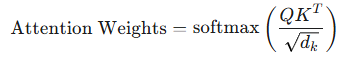




#### 5. Normalize Attention Weights with Softmax

The softmax function converts the scaled scores into a probability distribution, ensuring weights sum to 1 for each query.

#### 6. Compute Context-Weighted Embeddings 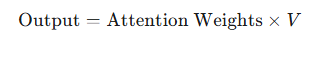

Finally, we multiply the normalized attention weights by the value vectors (V) to get the context-weighted embeddings. This is the weighted sum we discussed.

#### 7. Illustrating the Weighted Sum (for a single query)

To make it concrete, let's manually calculate the 4th context_weighted_embeddings (index 3) to see how it's a weighted sum of values.

# NOW - LAB WORK ( SHARE DOC FILE)

Before starting NEXT TOPIC

# NEXT TOPIC

# CAUSAL MASKING

In a standard Transformer encoder's self-attention, each word can attend to all other words in the input sequence, both before and after it. This is great for understanding context in a static sentence.


However, imagine you're training a model to write a story, one word at a time. If, when predicting the third word, the model could "see" the actual fourth, fifth, or sixth words (which haven't been generated yet), it would be "cheating." It wouldn't be learning to predict genuinely based only on what has come before. This is a problem known as **data leakage or look-ahead bias.**


This isn't a problem if all we're doing is creating embeddings (or sequences) based on whole passages of text. It does pose a problem, however, if we're trying to develop a model that can generate new sequences given an initial sequence (or prompt).

- For tasks like text classification or summarization where you have the entire input available upfront, looking at future words is fine and even beneficial.

- But for tasks like predicting the next word in a sequence or machine translation decoding (generating the target sentence word by word), the model must only rely on information up to the current point. It must operate in an **autoregressive manner.**

### The Solution: Causal Masking

"This problem is solved by using causal masking."
Causal masking (also known as **look-ahead masking or masked self-attention)** is a technique applied specifically in the self-attention mechanism of the Transformer's decoder (and decoder-only models like GPT).

###### Causal masking matrices can be constructed to flag which attention weights should be set to zero so that causal relationships between embeddings aren't broken.


- During the calculation of attention scores, a causal mask is applied. This mask is typically an upper triangular matrix (including the diagonal) filled with very large negative numbers (like negative infinity) in the positions corresponding to "future" tokens.

- When softmax is applied to these masked scores, the terms become effectively zero. This forces the attention weights for future tokens to be zero, meaning the current token cannot attend to any subsequent tokens in the sequence.

**For example, when calculating the representation for the first word, it can only attend to itself. When calculating for the second word, it can attend to the first word and itself, but not the third, fourth, or fifth words, and so on.**

In [227]:
#This line of code specifically constructs the mask that implements the "causal" or "look-ahead" behavior
causal_mask = torch.triu(torch.full((n_tokens, n_tokens), True), diagonal=1)
causal_mask

#True means "apply the mask/block this information," 
#False means "do not mask/allow this information through."

tensor([[False,  True,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True,  True],
        [False, False, False,  True,  True,  True,  True],
        [False, False, False, False,  True,  True,  True],
        [False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True],
        [False, False, False, False, False, False, False]])

This causal_mask is precisely the mechanism to prevent the "cheating" we talked about in sequence generation.

In the matrix above, True at (row, col) means that the token at row (as a query) is forbidden from attending to the token at col (as a key).

Since True appears only for respective col and row (i.e., tokens that come after the current query token), this mask ensures that:

When the attention mechanism calculates the context for token 0, it can only use information from token 0 itself (not 1, 2, 3).
When calculating for token 1, it can use information from token 0 and 1, but not 2 or 3.
And so on.

During the attention calculation, this boolean mask is typically used to set the attention scores for the "forbidden" (future) connections to a very large negative number. After softmax, these large negative numbers effectively become zero, meaning the model assigns no attention to future tokens. This enforces the autoregressive property, allowing the model to learn to predict sequences step-by-step based only on past information.

Which we will apply directly to the attention weights.

In [230]:
#This step directly implements the "causal" or "look-ahead" constraint. 
# For any token being processed, it prevents its attention mechanism from looking at or gaining information from 
#tokens that appear later in the sequence.

causal_attn_weights = attn_weights.masked_fill(causal_mask, -1e10)
causal_attn_weights[2]


#-1e10 is a very large negative number (e.g., -10,000,000,000). 
#It's used so that when this value goes through the softmax function, 
#it results in an output extremely close to zero, effectively "masking out" or nullifying the attention to that position.

tensor([-1.9434e+00, -2.3985e+00,  3.1176e+01, -1.0000e+10, -1.0000e+10,
        -1.0000e+10, -1.0000e+10], grad_fn=<SelectBackward0>)

In [231]:
causal_attn_weights

tensor([[ 2.6372e+01, -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10,
         -1.0000e+10, -1.0000e+10],
        [ 7.1022e+00,  2.6525e+01, -1.0000e+10, -1.0000e+10, -1.0000e+10,
         -1.0000e+10, -1.0000e+10],
        [-1.9434e+00, -2.3985e+00,  3.1176e+01, -1.0000e+10, -1.0000e+10,
         -1.0000e+10, -1.0000e+10],
        [-2.6912e+00,  9.1110e+00, -1.8537e+00,  3.8959e+01, -1.0000e+10,
         -1.0000e+10, -1.0000e+10],
        [-1.3581e+00, -6.4315e+00,  1.8425e+00,  9.0506e-01,  1.7466e+01,
         -1.0000e+10, -1.0000e+10],
        [ 2.3189e+00, -8.4562e-01, -8.3189e+00,  3.8310e+00,  5.8041e-02,
          2.7055e+01, -1.0000e+10],
        [ 5.8710e+00,  2.7615e+00,  6.4332e+00, -1.1257e-01, -4.7970e+00,
          2.4741e+00,  1.7596e+01]], grad_fn=<MaskedFillBackward0>)

And apply scaling and normalisation as before.

In [232]:
causal_attn_weights_norm = F.softmax(
    causal_attn_weights / math.sqrt(EMBEDDING_DIM), dim=1
)
causal_attn_weights_norm.sum(dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       grad_fn=<SumBackward1>)

From which we can compute causal context-aware embeddings.

In [220]:
causal_context_weighted_embeddings = torch.matmul(
    causal_attn_weights_norm, embedded_tokens
)
causal_context_weighted_embeddings.shape

torch.Size([7, 32])

In [234]:
causal_context_weighted_embeddings[2]

tensor([-0.9675, -0.8661,  0.2087,  1.0499,  0.5592, -1.9855, -2.5107, -1.2424,
        -1.6460,  1.1926,  0.0916, -0.2529,  0.4588,  0.1437,  0.8439,  0.5035,
        -0.3156, -0.6376,  0.4284, -1.5293,  0.6805,  0.8565, -0.5740,  2.2220,
         0.1626,  0.6732,  0.4924, -0.3094, -0.2629,  0.0815,  0.2841,  0.1073],
       grad_fn=<SelectBackward0>)

The integrity of the causal structure is easily demonstrated.

In [239]:
causal_context_weighted_embeddings_3 = (
    causal_attn_weights_norm[3, 0] * embedded_tokens[0]
    + causal_attn_weights_norm[3, 1] * embedded_tokens[1]
    + causal_attn_weights_norm[3, 2] * embedded_tokens[2]
    + causal_attn_weights_norm[3, 3] * embedded_tokens[3]
)

torch.allclose(
    causal_context_weighted_embeddings_3, causal_context_weighted_embeddings[3]
)

True

In [240]:
causal_context_weighted_embeddings_3

tensor([-0.9232,  0.1174, -0.5002,  2.4231, -0.5507,  1.8121, -0.7147,  0.8989,
        -0.3302, -0.4308, -0.1056,  2.4439, -0.2833, -1.5705, -0.8767, -1.6205,
        -1.1540,  1.6172, -1.0346, -0.7218,  0.6956, -0.2110,  0.2652, -0.4011,
        -0.6814,  0.6910,  1.7461, -0.9588, -0.5582, -0.5687, -1.0125,  1.2507],
       grad_fn=<AddBackward0>)

## Parametrised Self-Attention

Parametrised Self-Attention refers to a variation of the self-attention mechanism where additional learnable parameters are introduced into the attention computation. This allows the model to adaptively control how it distributes attention across input tokens.

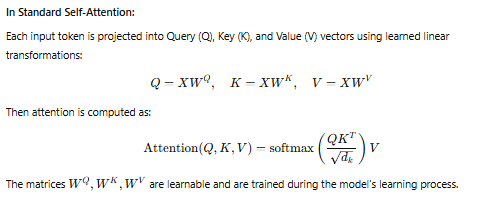


##### What Makes Parametrised Self-Attention Different?

While standard self-attention already includes parameters (via the Q, K, V projections), the term **"parametrised self-attention" typically refers to further enhancements where:**

- Additional parameters are introduced into the attention score calculation or the softmax operation.

- Learnable biases, temperature scaling factors, or gating mechanisms are included.

- Multi-head attention components may be further parameterised with learned transformations or scaling terms.



### Queries, Keys and Values

In this setup, the values contain the information that we wish to access via a query that is made on a set of keys (that map to the values), such that the context-aware embeddings can now be computed as,

$$
\vec{z_{i}} = \sum_{j=1}^{N}{a_{ij} \times \vec{v_{j}}}
$$

Where, $a_{ij} = q_{i}^{T} \cdot k_{i}$ - i.e., the attention weights now represent the distance between the query and keys.

Very often we only have a single sequence to work with, so the model will have to learn how to infer the queries, keys and values from this. We can enable this level of plasticity by defining three  $N \times N$ weight matrices, $\textbf{U}_{q}$, $\textbf{U}_{k}$ and $\textbf{U}_{v}$.

In [241]:
u_q = torch.rand(n_tokens, n_tokens)
u_k = torch.rand(n_tokens, n_tokens)
u_v = torch.rand(n_tokens, n_tokens)

In [242]:
print(u_q, u_k, u_v)

tensor([[0.3267, 0.4655, 0.4520, 0.1542, 0.2377, 0.9663, 0.0501],
        [0.4439, 0.9655, 0.2292, 0.2920, 0.0828, 0.2382, 0.5602],
        [0.5297, 0.6805, 0.4546, 0.4096, 0.0779, 0.3459, 0.3997],
        [0.9526, 0.7420, 0.3855, 0.2585, 0.5706, 0.5734, 0.8364],
        [0.8942, 0.1112, 0.1338, 0.9513, 0.1081, 0.0058, 0.3863],
        [0.2312, 0.3384, 0.6034, 0.8386, 0.0122, 0.3942, 0.9671],
        [0.0601, 0.8062, 0.6628, 0.5018, 0.7898, 0.8684, 0.8115]]) tensor([[0.1374, 0.1865, 0.9216, 0.0378, 0.6176, 0.0443, 0.4827],
        [0.0936, 0.6816, 0.5175, 0.3725, 0.2338, 0.2905, 0.7091],
        [0.4406, 0.3339, 0.0479, 0.0760, 0.4483, 0.6683, 0.5915],
        [0.9761, 0.3554, 0.2448, 0.8257, 0.3642, 0.5375, 0.3767],
        [0.5081, 0.3003, 0.0351, 0.1262, 0.1944, 0.3213, 0.2177],
        [0.6218, 0.7253, 0.4691, 0.5260, 0.1900, 0.0304, 0.9415],
        [0.4232, 0.1390, 0.8638, 0.2158, 0.0519, 0.0850, 0.6413]]) tensor([[0.9981, 0.5765, 0.0551, 0.0658, 0.6691, 0.6790, 0.0327],
        

From which we can define the query, keys and values as functions of $\textbf{x}$.

In [223]:
q = torch.matmul(u_q, embedded_tokens)
k = torch.matmul(u_k, embedded_tokens)
v = torch.matmul(u_v, embedded_tokens)

q.shape == k.shape == v.shape == embedded_tokens.shape

True

We then recompute our parameterised attention weights using the same steps we used before.

In [243]:
attn_weights_param = torch.empty(n_tokens, n_tokens)

for i in range(n_tokens):
    for j in range(n_tokens):
        attn_weights_param[i, j] = torch.dot(q[i], k[j])

attn_weights_param_norm = F.softmax(
    attn_weights_param / math.sqrt(EMBEDDING_DIM), dim=1
)
context_weighted_embeddings_param = torch.matmul(attn_weights_param_norm, v)

context_weighted_embeddings_param.shape

torch.Size([7, 32])

In [244]:
context_weighted_embeddings_param

tensor([[-1.3402e+00, -9.0176e-01,  1.0495e+00,  4.4885e-01,  1.4480e-02,
          9.6893e-02, -1.4673e+00, -8.1557e-01, -3.0205e+00,  1.9643e+00,
          3.5611e-01,  5.8797e-01, -7.5645e-01, -4.1993e-01, -4.5160e-01,
         -3.5341e+00, -5.1716e-01, -4.4866e-02,  3.9432e-01,  3.3562e-01,
          6.8779e-01, -2.4539e+00,  1.4351e+00,  1.0636e+00, -2.0620e-01,
         -9.9903e-01,  6.1864e-01, -4.3959e-01, -1.6865e+00, -2.0701e+00,
          1.3676e-01, -5.3816e-01],
        [-1.7416e+00, -1.1869e+00,  1.5808e+00,  8.7009e-01,  2.0919e-02,
         -1.5874e-01, -1.5991e+00, -7.1598e-01, -3.9265e+00,  2.4875e+00,
          6.9371e-01,  7.1654e-01, -9.0303e-01, -5.0161e-01, -2.0128e-02,
         -4.2432e+00, -6.0477e-01, -2.0229e-01,  5.1695e-01,  2.5324e-01,
          1.3794e+00, -2.6645e+00,  1.9534e+00,  1.5553e+00,  4.3253e-02,
         -7.4512e-01,  8.3696e-01, -3.3419e-01, -2.2268e+00, -2.8499e+00,
          2.4805e-01, -7.4871e-01],
        [-1.2831e+00, -1.0011e+00,  1.35

And verify that the context-aware embeddings behave as we'd expect.

In [245]:
context_weighted_embeddings_param_3 = (
    attn_weights_param_norm[3, 0] * v[0]
    + attn_weights_param_norm[3, 1] * v[1]
    + attn_weights_param_norm[3, 2] * v[2]
    + attn_weights_param_norm[3, 3] * v[3]
    + attn_weights_param_norm[3, 4] * v[4]
    + attn_weights_param_norm[3, 5] * v[5]
    + attn_weights_param_norm[3, 6] * v[6]
  #  + attn_weights_param_norm[3, 7] * v[7]
)

torch.allclose(
    context_weighted_embeddings_param_3, context_weighted_embeddings_param[3]
)

True

### Multi-Head Attention

<center><img src="images/attention.png" width="500"/></center>

In what follows we demonstrate how use the parametrised attention mechanism sketched out above to develop the multi-head attention block that forms the foundation of all transformer architectures. Our aim here is purely didactic - the functions defined below won't yield anything you can train (refer to the full codebase in the `modelling` directory for this), but they do demonstrate how these algorithm are composed.

We start by encapsulating the parametrised attention mechanism within a single function.

In [246]:
def attention(
    query: torch.Tensor,
    keys: torch.Tensor,
    values: torch.Tensor,
    causal_masking: bool = False,
) -> torch.Tensor:
    """Compute single attention head."""
    n_tokens, embedding_dim = query.shape
    attn_weights = torch.matmul(query, keys.T) / math.sqrt(EMBEDDING_DIM)
    if causal_masking:
        mask = torch.triu(torch.full((n_tokens, n_tokens), True), diagonal=1)
        attn_weights = attn_weights.masked_fill(mask, -1e10)
    attn_weights_norm = attn_weights.softmax(dim=1)
    context_weighted_embeddings = torch.matmul(attn_weights_norm, values)
    return context_weighted_embeddings


attn_head_out = attention(q, k, v)
attn_head_out.shape

torch.Size([7, 32])

And use this to define an attention mechanism with multiple attention blocks or 'heads'. This enables models to learn multiple 'contexts' - different sets of keys and values - not unlike how convolutional neural networks use multiple sets of filter banks to detect features at different scales (it is likely that this analog is what motivated this design).

In [247]:
def multi_head_attention(
    x_q: torch.Tensor,
    x_k: torch.Tensor,
    x_v: torch.Tensor,
    n_heads: int,
    causal_masking: bool = False,
) -> torch.Tensor:
    """Computing attention with multiple heads."""
    n_tokens, embedding_dim = embedded_tokens.shape
    
    u_q = torch.rand(n_heads, n_tokens, n_tokens)
    u_k = torch.rand(n_heads, n_tokens, n_tokens)
    u_v = torch.rand(n_heads, n_tokens, n_tokens)

    attn_head_outputs = torch.concat(
        [attention(u_q[h] @ x_q, u_k[h] @ x_k, u_v[h] @ x_v) for h in range(n_heads)],
        dim=1,
    )

    w_out = torch.rand(n_heads * embedding_dim, embedding_dim, requires_grad=True)
    return torch.matmul(attn_head_outputs, w_out)


multi_head_attn_out = multi_head_attention(
    embedded_tokens, embedded_tokens, embedded_tokens, n_heads=3
)
multi_head_attn_out.shape

torch.Size([7, 32])

Note, that `@` is a shorthand operator for matrix multiplication and that `torch.rand(n_heads, n_tokens, n_tokens)` could also be replaced with `nn.Linear` as these matrices are equivalent to passing the inputs through a fully-connected (or dense) network layer.

## Transformers

<center><img src="images/encoder_decoder.png" width="500"/></center>

We now know enough to assemble the basic transformer architecture, starting with a single layer encoder.

In [248]:
def transformer_encoder_layer(
    src_embedding: torch.Tensor, n_heads: int, causal_masking: bool = False
) -> torch.Tensor:
    """Transformer encoder layer."""
    x = multi_head_attention(src_embedding, src_embedding, src_embedding, n_heads)
    x = F.layer_norm(x + src_embedding, x.shape)

    linear_1 = nn.Linear(EMBEDDING_DIM, 2 * EMBEDDING_DIM)
    linear_2 = nn.Linear(2 * EMBEDDING_DIM, EMBEDDING_DIM)

    x = x + F.relu(linear_2(linear_1(x)))

    return x


encoder_output = transformer_encoder_layer(embedded_tokens, n_heads=2)
encoder_output.shape

torch.Size([7, 32])

In [249]:
encoder_output

tensor([[-0.3776, -0.1356,  0.7474, -0.9005, -0.4754,  1.3559,  0.1214, -2.4067,
         -1.1127, -0.7242,  1.8323, -2.1883, -2.0212, -1.9501, -1.0882,  2.6327,
         -0.7160, -1.7808,  2.3187,  0.0698,  0.1030, -0.0127,  0.5671,  0.4858,
         -0.3033,  0.0999,  0.6101,  1.2313, -0.6752, -0.9860, -0.3737, -0.2211],
        [-0.0591,  0.7692,  1.0290,  0.5896,  0.7692,  1.6560,  0.4770, -1.6586,
         -0.2036, -0.1678,  1.5786, -0.7560, -0.3748, -0.7012, -0.1799,  2.7993,
          0.2920, -0.3907,  1.9928,  0.3593,  0.7429,  0.2202,  0.8612,  1.1996,
          0.5325,  0.4564,  1.2375,  1.9546,  0.5605, -0.0636,  0.9245,  0.7193],
        [-0.5756,  0.0158,  0.9665,  0.7488,  0.4773,  0.2659, -0.2334, -1.7692,
         -0.9204, -0.3842,  1.2572, -0.7900, -0.6757, -0.8916,  0.1852,  3.2563,
          0.1746, -0.8516,  1.8191, -0.4218,  1.1977,  0.8192,  0.4798,  1.4812,
          0.5145,  0.6399,  0.7362,  1.4251,  0.4186, -0.2405,  0.7059,  0.8169],
        [-0.3748,  0.4095

And then a single layer decoder.

In [250]:
def transformer_decoder_layer(
    src_embedding: torch.Tensor,
    target_embedding: torch.Tensor,
    n_heads: int,
    causal_masking: bool = False,
) -> torch.Tensor:
    """Transformer decoder layer."""
    x = multi_head_attention(
        target_embedding, target_embedding, target_embedding, n_heads
    )
    x = F.layer_norm(x + target_embedding, x.shape)
    x = x + multi_head_attention(src_embedding, src_embedding, x, n_heads)
    x = F.layer_norm(x, x.shape)

    linear_1 = nn.Linear(EMBEDDING_DIM, 2 * EMBEDDING_DIM)
    linear_2 = nn.Linear(2 * EMBEDDING_DIM, EMBEDDING_DIM)

    x = x + F.relu(linear_2(linear_1(x)))

    return x


decoder_output = transformer_decoder_layer(embedded_tokens, embedded_tokens, n_heads=2)
decoder_output.shape

torch.Size([7, 32])

## Where to go from Here

Now that we have a basic insight into attention and transformers we will be using PyTorch's `torch.nn.TransformerEncoderLayer` and `torch.nn.TransformerDecoderLayer` modules in subsequent notebooks, to compose and train transformer-based models for tackling NLP tasks (e.g., text generation).

## Useful Resources

1. [Introduction to PyTorch](https://alexioannides.com/data-science-and-ml-notebook/pytorch/)
2. [PyTorch docs](https://pytorch.org/docs/stable/index.html)
3. [The Annotated Transformer](http://nlp.seas.harvard.edu/annotated-transformer/)